# Sample APP $-$ INFERENCE

**Objective**

 - load FTS transfer error
 - apply K-Means clustering (two modes):
   - static use of pre-trained model
   - re-training on the new data
   
**Note** The *word2vec* language model is pre-trained once (possible once in a while) and then fixed.

### Spark Session 

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("sample_app_inference").getOrCreate()
spark

CPU times: user 55.1 ms, sys: 33.2 ms, total: 88.4 ms
Wall time: 11 s


## Import data

**Read from HDFS**

In [2]:
# %%time 

# import pyspark.sql.functions as F
# # 19th October 2019
# day = "2020/03/05"

# # FTS data path
# path_list = ['/project/monitoring/archive/fts/raw/complete/{}/*'.format(day)]
# # path_list = "/project/monitoring/archive/fts/raw/complete/2019/10/18/*"

# # load the data in the json file
# all_transfers = spark.read.json(path_list)

# # retrieve just data
# all_transfers = all_transfers.select("data.*")

# # filter test_errors only
# test_errors = all_transfers.filter(all_transfers["t_final_transfer_state_flag"] == 0)

# # sample 100 random rows
# n = test_errors.count()
# test_errors = test_errors.sample(withReplacement=False, fraction=1.*100/n).limit(100)

# # add row id and select only relevant variables
# test_errors = test_errors.withColumn("msg_id", F.monotonically_increasing_id()).select(
#     "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# # show top 10 rows
# test_errors.toPandas().head(10)

CPU times: user 616 ms, sys: 154 ms, total: 770 ms
Wall time: 2min 9s


,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414544375
1,1,TRANSFER Transfer canceled because the gsiftp...,dcgftp.usatlas.bnl.gov,srm.ndgf.org,0
2,2,TRANSFER ERROR: Copy failed with mode 3rd pus...,golias100.farm.particle.cz,gfe02.grid.hep.ph.ic.ac.uk,1583427213286
3,3,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
4,4,TRANSFER ERROR: Copy failed with mode 3rd pul...,lapp-se01.in2p3.fr,lcg-lrz-http.grid.lrz.de,1583400047771
5,5,Result (Neon): Could not read status line: con...,lapp-testse01.in2p3.fr,lapp-xdc01.in2p3.fr,0
6,6,TRANSFER globus_ftp_client: the server respon...,sdrm.t1.grid.kiae.ru,torik1.ulakbim.gov.tr,0
7,7,TRANSFER globus_ftp_client: the server respon...,cmsio.rc.ufl.edu,cmseos-gridftp.fnal.gov,0
8,8,DESTINATION SRM_PUTDONE Error on the surl srm:...,eoscmsftp.cern.ch,srm-cms.cern.ch,1583414700237
9,9,globus_ftp_client: the server responded with a...,eosatlassftp.cern.ch,storm-01.roma3.infn.it,0


**Save extracted data as json file**

In [117]:
# test_errors.coalesce(1).write.format('json').mode('overwrite').save('fts_05mar20.json')


**Alternative: read from csv file**

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

test_errors = spark.read.json("fts_05mar20.json").select(
    "msg_id", "t__error_message", "src_hostname", "dst_hostname", "timestamp_tr_comp")

# visualize data
test_errors.toPandas().head(10)

,msg_id,t__error_message,src_hostname,dst_hostname,timestamp_tr_comp
0,0,Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory.,srm-eospublic.cern.ch,srm-public.cern.ch,0
1,1,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",gftp.t2.ucsd.edu,dcache-se-cms.desy.de,0
2,2,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",heplnx204.pp.rl.ac.uk,storm-fe-cms.cr.cnaf.infn.it,0
3,3,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500",se01.grid.cyfronet.pl,se.hpc.utfsm.cl,1583439822407
4,4,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 404 : File not found",ccdavatlas.in2p3.fr,gftp01.ncg.ingrid.pt,1583423079983
5,5,DESTINATION OVERWRITE Result HTTP 502 : Unexpected server error: 502 after 1 attempts,f-dpm000.grid.sinica.edu.tw,eosatlashttp.cern.ch,0
6,6,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup.",lcg-se0.ifh.de,grid-dav.rzg.mpg.de,1583434383382
7,7,TRANSFER globus_ftp_client: the server responded with an error 500 Command failed. : Error registering globus write error: Unknown error 2033,eosatlassftp.cern.ch,dcsrm.usatlas.bnl.gov,0
8,8,"TRANSFER ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode] HTTP/1.1 404 Not Found Detail: <!DOCTYPE HTML PUBLIC -//IETF//DTD HTML 2.0//EN> <html><head> <title>404 Not Found</title> </head><body> <h1>Not Found</h1> <p>The requested URL /gridsite-delegation was not found on this server.</p> </body></html> .",dav.ndgf.org,f-dpm000.grid.sinica.edu.tw,1583431419198
9,9,"TRANSFER Transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded, or all performance markers during that period indicated zero bytes transferred",storm-fe.cr.cnaf.infn.it,head01.aglt2.org,0


## Inference 

#### Static predictions

In [6]:
# %%time
# import importlib
# import kmeans
# importlib.reload(kmeans)

# test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
#                     w2v_model_path="w2v_model", tks_vec="message_vector", ft_col="features",
#                     kmeans_mode="load", kmeans_model_path="best_K_model",
#                     pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
#                     distance="cosine", opt_initSteps=10, opt_tol=0.0001, opt_maxIter=30, #K_optim
#                     tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
#                     )

CPU times: user 234 ms, sys: 57.2 ms, total: 291 ms
Wall time: 4.95 s


#### Online re-training 

In [5]:
%%time
import kmeans
import importlib
importlib.reload(kmeans)

test_predictions = kmeans.kmeans_inference(original_data=test_errors, msg_col="t__error_message", id_col="msg_id", 
                    w2v_model_path="w2v_model", tks_vec="message_vector", ft_col="features",
                    kmeans_mode="train", kmeans_model_path=None,
                    pred_mode="static", new_cluster_thresh=None,# update_model_path=None, #kmeans_predit
                    distance="cosine", opt_initSteps=10, opt_tol=0.0001, opt_maxIter=30, #K_optim
                    tr_initSteps=200, tr_tol=0.000001, tr_maxIter=100, #train_kmeans
                    )

Started at: 2020-03-12 12:47:41

With K=2
Within Cluster Sum of Squared Errors = 7.2657
Silhouette with cosine distance = 0.8761

Time elapsed: 0 minutes and 7 seconds.
------------------------------------------------------------
Started at: 2020-03-12 12:47:49

With K=3
Within Cluster Sum of Squared Errors = 5.5116
Silhouette with cosine distance = 0.5418

Time elapsed: 0 minutes and 2 seconds.
------------------------------------------------------------
Started at: 2020-03-12 12:47:52

With K=4
Within Cluster Sum of Squared Errors = 4.2552
Silhouette with cosine distance = 0.4602

Time elapsed: 0 minutes and 2 seconds.
------------------------------------------------------------
Started at: 2020-03-12 12:47:55

With K=5
Within Cluster Sum of Squared Errors = 3.4547
Silhouette with cosine distance = 0.5344

Time elapsed: 0 minutes and 2 seconds.
------------------------------------------------------------
Started at: 2020-03-12 12:47:57

With K=6
Within Cluster Sum of Squared Errors =

#### Visualization 

##### Summary 

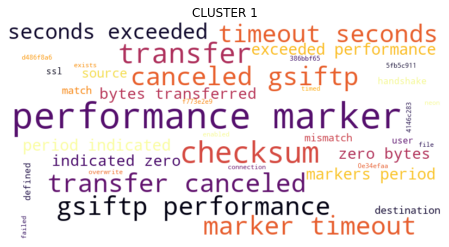

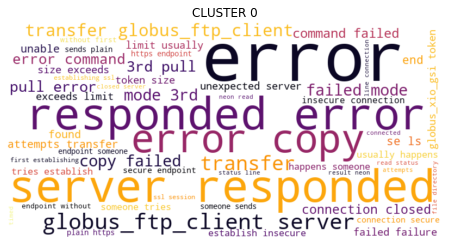

,n_messages,unique_strings,unique_patterns,top_3_msg,top_5_src,top_4_dst
prediction,,,,,,
0,79,52,41,"[{'msg': 'transfer globus_ftp_client the server responded with an error 500 500 command failed 500 globus_xio_gsi token size exceeds limit usually happens when someone tries to establish a insecure connection with a secure endpoint e.g when someone sends plain http to a https endpoint without first establishing a ssl session 500 end', 'n': 6}, {'msg': 'error reported from srm_ifce 2 [se][ls][srm_invalid_path] no such file or directory', 'n': 5}, {'msg': 'result (neon) could not read status line connection was closed by server after 1 attempts', 'n': 5}]","[{'src': 'dcsrm.usatlas.bnl.gov', 'n': 5}, {'src': 'lapp-testse01.in2p3.fr', 'n': 5}, {'src': 'srm-eospublic.cern.ch', 'n': 5}, {'src': 'eosatlassftp.cern.ch', 'n': 4}, {'src': 'bohr3226.tier2.hep.manchester.ac.uk', 'n': 3}]","[{'dst': 'torik1.ulakbim.gov.tr', 'n': 8}, {'dst': 'eoscmsftp.cern.ch', 'n': 5}, {'dst': 'lapp-xdc01.in2p3.fr', 'n': 5}, {'dst': 'srm-public.cern.ch', 'n': 5}]"
1,12,6,6,"[{'msg': 'transfer transfer canceled because the gsiftp performance marker timeout of 360 seconds has been exceeded or all performance markers during that period indicated zero bytes transferred', 'n': 7}, {'msg': 'destination checksum (neon) ssl handshake failed connection timed out during ssl handshake', 'n': 1}, {'msg': 'destination file exists and overwrite is not enabled', 'n': 1}]","[{'src': 'dcsrm.usatlas.bnl.gov', 'n': 2}, {'src': 'eosatlassftp.cern.ch', 'n': 2}, {'src': 'gftp.t2.ucsd.edu', 'n': 2}, {'src': 'heplnx204.pp.rl.ac.uk', 'n': 2}, {'src': 'clrlcgse01.in2p3.fr', 'n': 1}]","[{'dst': 'head01.aglt2.org', 'n': 3}, {'dst': 'ccsrm.in2p3.fr', 'n': 1}, {'dst': 'charon01.westgrid.ca', 'n': 1}, {'dst': 'dcache-se-cms.desy.de', 'n': 1}]"


In [11]:
import cluster_visualization
import importlib
importlib.reload(cluster_visualization)

abs_dataset, summary = cluster_visualization.summary(test_predictions,
                                        clust_col="prediction", tks_col="stop_token_1",
                                        abs_tks_out="abstract_tokens", abs_tks_in="tokens_cleaned",
                                        abstract=True, n_mess=3, wrdcld=True,
                                        original=test_errors, src_col="src_hostname", dst_col="dst_hostname", n_src=5, n_dst=4)

summary

##### Scatterplot 

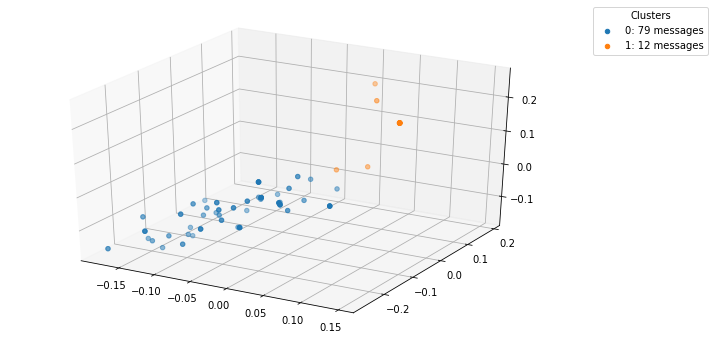

In [13]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt
import numpy as np
from kmeans import get_k_best, plot_metrics

data = test_predictions.select("t__error_message", "features", "prediction").toPandas()
k = test_predictions.select("prediction").distinct().count()
df = pd.DataFrame(None, columns=["cluster", "x", "y", "z"])
i=1

for clust_id in range(0, k):
    cluster = data["features"][data.prediction == clust_id]
    for row in cluster:
        x, y, z  = row
        df.loc[i] = [clust_id, x, y, z]
        i += 1 

# Create plot
fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(1, 1, 1, axisbg="1.0")
ax = fig.gca(projection='3d')
for clust_id in range(0, k):
    cluster_df = df[df.cluster == clust_id]
    _ = ax.scatter(cluster_df.x, cluster_df.y, cluster_df.z, label="{}: {} messages".format(clust_id, cluster_df.shape[0]) )
_ = ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#### Messages 

In [14]:
from termcolor import colored

for clust_id in range(0, k):
    cluster = data["t__error_message"][data.prediction == clust_id]
    print(colored("Cluster n.{}".format(clust_id), 'red'), "\n")
    for idx, row in enumerate(cluster.head(10)):
        print("{}.".format(idx), row, "\n\n")

Cluster n.0 

0. Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory. 


1. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 500 : Unexpected server error: 500  


2. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy HTTP 404 : File not found  


3. DESTINATION OVERWRITE   Result HTTP 502 : Unexpected server error: 502  after 1 attempts 


4. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: Transfer failed: failure: Failed to select pool: diskCacheV111.services.space.SpaceAuthorizationException: Unable to reserve space: user not authorized to reserve space in any linkgroup.  


5. TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : Error registering globus write error: Unknown error 2033    


6. TRANSFER  ERROR: Copy failed with mode 3rd pull, with error: copy 0) Could not get the delegation id: Could not get proxy request: Error 404 fault: SOAP-ENV:Server [no subcode]